In [4]:
import datasets
from datasets import load_dataset

In [5]:
dataset = load_dataset("nateraw/pascal-voc-2012", split='train')


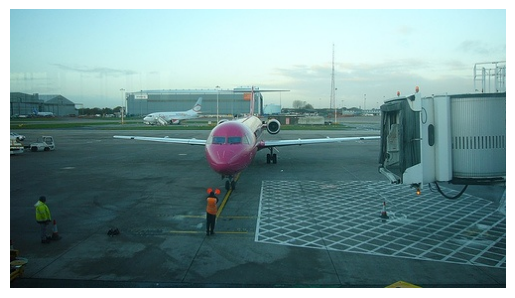

In [6]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import img_to_array
plt.axis('off')
plt.imshow(dataset[0]['image'])

In [7]:
import numpy as np
import tensorflow as tf

img_size = (128, 128)
num_imgs = len(dataset['image'])

def load_input_image(num):
    img = np.array(dataset[num]['image'].resize(img_size))
    img = tf.cast(img, tf.float32) / 255.0
    return img
    
def load_targets(num):
    img = img_to_array(dataset[num]['mask'].resize(img_size).convert('L'))
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype='float32')
targets = np.zeros((num_imgs, ) + img_size + (1, ), dtype='uint8')
for i in range(num_imgs):
    input_imgs[i] = load_input_image(i)
    targets[i] = load_targets(i)

In [8]:
TRAIN_LENGTH = int(len(dataset) * 0.8)

In [9]:
train_image = input_imgs[:-TRAIN_LENGTH]
train_target = targets[:-TRAIN_LENGTH]
val_image = input_imgs[-TRAIN_LENGTH:]
val_target = targets[-TRAIN_LENGTH:]

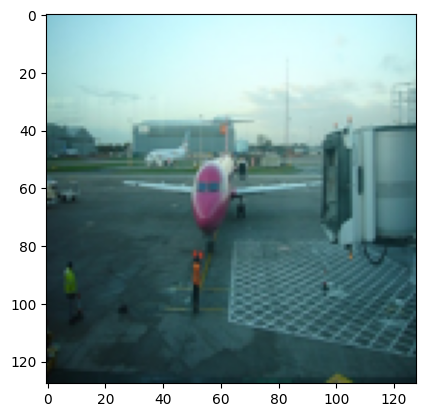

In [10]:
plt.imshow(train_image[0])

In [13]:
train_image.shape

(293, 128, 128, 3)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Input, MaxPooling2D, UpSampling2D, Concatenate ,Activation, Conv2DTranspose
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
def conv_batch(layer, filters):
    conv = Conv2D(filters, 3, padding='same')(layer)
    batch = BatchNormalization()(conv)
    act = Activation('relu')(batch)
    conv = Conv2D(filters, 3, padding='same')(act)
    batch = BatchNormalization()(conv)
    return Activation('relu')(batch)

def EncoderBlock(layer, filters):
    conv = conv_batch(layer, filters)
    pool = MaxPooling2D(2)(conv)
    return conv, pool

def DecoderBlock(layer, skip, filters):
    up = Conv2DTranspose(filters, 2, strides=2, padding='same')(layer)
    con = Concatenate()([up, skip])
    conv = conv_batch(con, filters)
    return conv

In [ ]:
def Unet(input_shape=(128, 128, 3)):
    inputs = Input(input_shape)
    
    s1, p1 = EncoderBlock(inputs, 64)
    s2, p2 = EncoderBlock(p1, 128)
    s3, p3 = EncoderBlock(p2, 256)
    s4, p4 = EncoderBlock(p3, 512)

    b = conv_batch(p4, 1024)

    d1 = DecoderBlock(b, s4, 512)
    d2 = DecoderBlock(d1, s3, 256)
    d3 = DecoderBlock(d2, s2, 128)
    d4 = DecoderBlock(d3, s1, 64)

    output= Conv2D(1, 1, padding='same', activation='softmax')(d4)

    model = Model(inputs=inputs, outputs= output)
    return model

In [ ]:
model = Unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

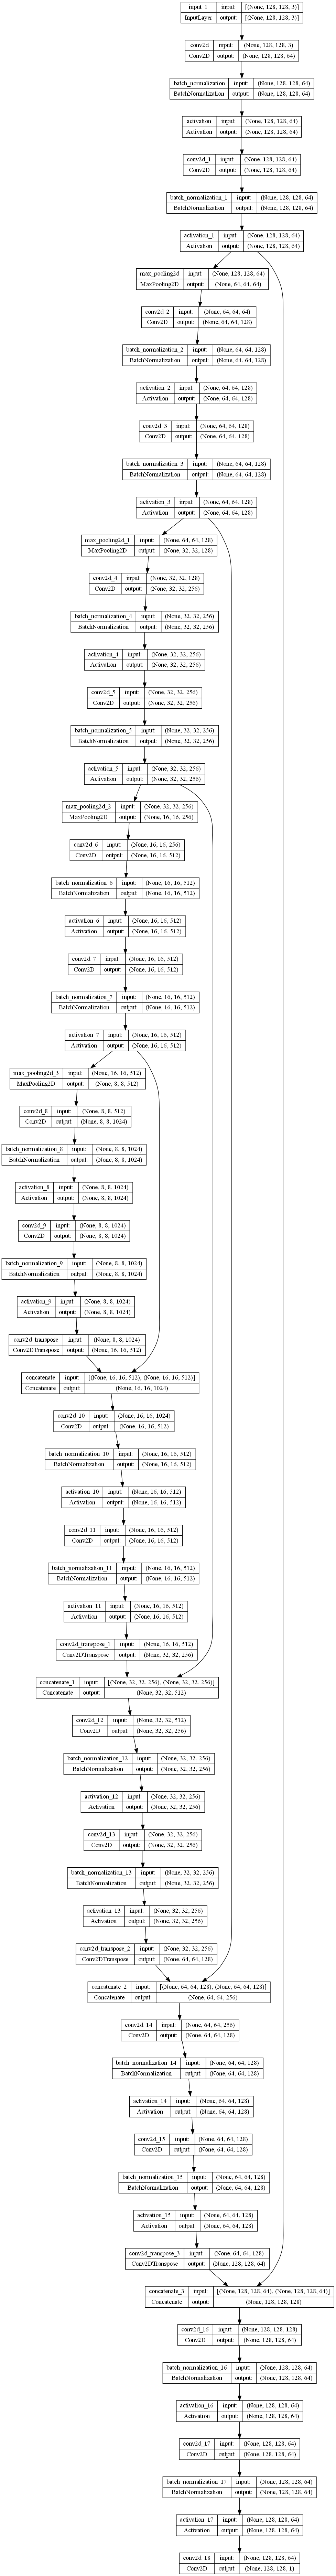

In [ ]:
tf.keras.utils.plot_model(model, to_file='U-Net.png', show_shapes=True)

In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"

model.compile(optimizer="Adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callbacks = [
    ModelCheckpoint('segmentation.keras', save_best_only=True)
]
history = model.fit(train_image, train_target, 
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_image, val_target))

Epoch 1/50
5/5 [==============================] - 59s 7s/step - loss: nan - accuracy: 4.9099e-04 - val_loss: nan - val_accuracy: 4.8474e-04
Epoch 2/50
5/5 [==============================] - 11s 2s/step - loss: nan - accuracy: 5.1120e-04 - val_loss: nan - val_accuracy: 4.8474e-04
Epoch 3/50
5/5 [==============================] - 11s 2s/step - loss: nan - accuracy: 5.1120e-04 - val_loss: nan - val_accuracy: 4.8474e-04
Epoch 4/50
5/5 [==============================] - 11s 2s/step - loss: nan - accuracy: 5.1120e-04 - val_loss: nan - val_accuracy: 4.8474e-04
Epoch 5/50
5/5 [==============================] - 11s 2s/step - loss: nan - accuracy: 5.1120e-04 - val_loss: nan - val_accuracy: 4.8474e-04
Epoch 6/50
5/5 [==============================] - 11s 2s/step - loss: nan - accuracy: 5.1120e-04 - val_loss: nan - val_accuracy: 4.8474e-04
Epoch 7/50
5/5 [==============================] - 11s 2s/step - loss: nan - accuracy: 5.1120e-04 - val_loss: nan - val_accuracy: 4.8474e-04
Epoch 8/50
5/5 [====

KeyboardInterrupt: 